# Economic Growth

# 8.4.1 モデルについて

あるcomposite goodを生産し、消費する経済を考える.

・毎年、財は数量$s$で始まり、うち$x$が投資に、残り$(s-x)$が消費に充てられる.

・また、social benefitとして$u(s-x)$が生じる.

・毎年はじめに利用できる財の量はcontinuous-valued Markov processによって以下のようにコントロールされる

$$s_{t+1} = \gamma x_t + \epsilon_{t+1}h(x_t)$$

・$\gamma$はcapital survival rate(1-減価償却率)、$h$は総生産関数、$\epsilon$は正の生産ショック(平均が1)を表す.

ここでは、現在、そして将来にわたるsocial benefitの総和を最大化するような消費と投資のpolicyについて考える.

・このモデルはinfinite horizonである.$ｘ$は投資量を決定するアクションである.

$$s\in[0,\infty), x\in[0,s]$$

・状態遷移関数(state transition function)は次のように表される.

$$g(s,x,\epsilon)=\gamma x + \epsilon h(x)$$

・reward functionは次のように表される.

$$f(s,x)=u(s-x)$$

ストック$s$が与えられたとき、現在と将来のsocial benefitの和はBellman equationを満たす.

$$V(s)=\max_{0\leq x \leq s}\{u(s-x) + \delta E_\epsilon V(\gamma x +\epsilon h(x))\}$$

$u'(0)=\infty$と$h(0)=0$を仮定すると、最適条件ではconstraintsは拘束力を持たない?

In [1]:
using QuantEcon
using BasisMatrices
using Optim

In [42]:
using CompEcon #要らない？

In [2]:
using Interpolations

In [3]:
using Plots

In [4]:
struct GrowthModel
    alpha::Float64
    beta::Float64
    gamma::Float64
    sigma::Float64
    delta::Float64 #discount factor
    s_vec::Vector{Float64}
end

In [5]:
n = 500 #ここを大きくするとdpsimulのspathが7.5に近づく
smin = 0
smax = 10
fspace = Basis(ChebParams(n, smin, smax))

snodes = nodes(fspace);

In [6]:
GM = GrowthModel(0.2, 0.5, 0.9,0.1,0.9, snodes[1])

GrowthModel(0.2, 0.5, 0.9, 0.1, 0.9, [2.4674e-5, 0.000222064, 0.000616838, 0.00120898, 0.00199846, 0.00298526, 0.00416933, 0.00555063, 0.00712909, 0.00890467  …  9.9911, 9.99287, 9.99445, 9.99583, 9.99701, 9.998, 9.99879, 9.99938, 9.99978, 9.99998])

In [7]:
function update_bellman!(GM::GrowthModel,V::Vector)
    a,b,g,sigma,d = GM.alpha, GM.beta, GM.gamma, GM.sigma, GM.delta
    V_func = LinInterp(GM.s_vec, V)
    V_new = similar(V)
    x_opt = similar(V)
    
    nshocks = 3
    e,w = qnwlogn(nshocks,-(sigma^2)/2,sigma^2)
    
    for (s_idx,s) in enumerate(GM.s_vec)
        objective(x) = -(((s - x)^(1 - a)/(1 - a)) + d * dot(V_func.(g*x + e*(x^b)), w))
        opt = optimize(objective, 1e-10, s)
        V_new[s_idx] = - opt.minimum
        x_opt[s_idx] = opt.minimizer
    end
    return V_new,x_opt
end

update_bellman! (generic function with 1 method)

In [8]:
V = Vector{Float64}(length(GM.s_vec))
for i in 1:length(GM.s_vec)
V[i] = 5
end

In [67]:
n = 500
V_computed = similar(V)
x_opt = similar(V)
resid = Vector{Float64}(n)

for i in 1:n
    V_func =  LinInterp(snodes[1], V)
    V_computed, x_opt = update_bellman!(GM,V)
    for j in 1:length(V_computed)
        resid[j] =  V_computed[j] - V_func(snodes[1][j])
    end
    copy!(V, V_computed)
end


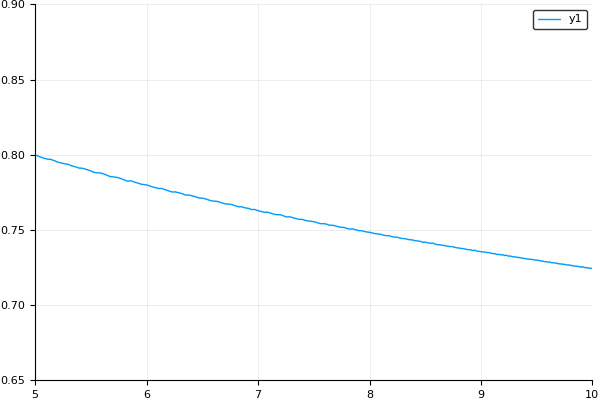

In [68]:
x_per = similar(V)
for i in 1:length(x_per)
    x_per[i] = x_opt[i] / GM.s_vec[i]
end

plot(GM.s_vec, x_per,xlim=(5,10),ylim=(0.65,0.9))


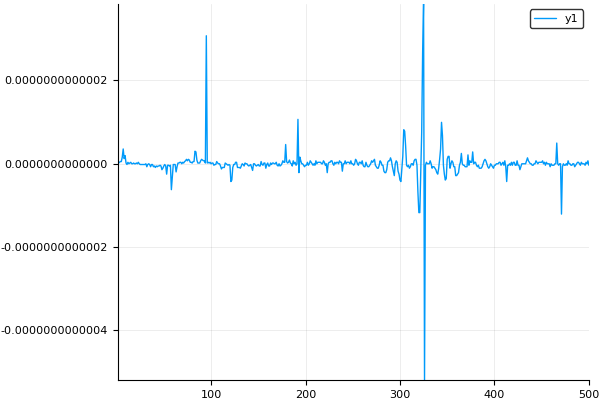

In [69]:
plot(resid)

LQapprox部分の実装

In [13]:
GM::GrowthModel
a,b,gamma,sigma,d = GM.alpha, GM.beta, GM.gamma, GM.sigma, GM.delta

estar = 1 #教科書訂正
xstar = ((1 - d*gamma)/(d*b))^(1/(b - 1))
sstar = gamma*xstar + xstar^b
pstar = (sstar - xstar).^(- a); #λ=u'

In [ ]:
#derivatives of reward function
f(s,x) = (s - x)^(1 - a)/(1 - a)
fx(s,x) = (-s + x)^(-a)
fxx(s,x) = (-a*(s - x))^(-a - 1)

f_rep(s,x) = f(sstar,xstar) + fx(sstar,x)(x - xstar) + 1/2*((x - xstar)^2)*fxx(sstar,x)
        + fx(s,xstar)(s - sstar) + 1/2*((s - sstar)^2)*fxx(s,xstar)

g_rep(c) = g(xstar) + gx(xstar)(x - xstar)

In [78]:
GM::GrowthModel
a,b,gamma,sigma,d = GM.alpha, GM.beta, GM.gamma, GM.sigma, GM.delta

nshocks = 3
e,w = qnwlogn(nshocks,-(sigma^2)/2,sigma^2)

A = [b*estar*(xstar) gamma*xstar+(1+b)*estar*(xstar^b)+gamma;
     0                 1]
B = [-(b*estar*(xstar));
     0]
C = zeros(2,1)

R = zeros(2,2)
Q = -1/2*a*((sstar -xstar)^(-a-1))

lq = LQ(Q,R,A,B,C; bet=d)

x0 = [5.0;1.0]

slq,xlq = compute_sequence(lq, x0)

([5.0 23.5247 … 2.25029e45 6.3114e45; 1.0 1.0 … 1.0 1.0], [-0.0 -0.0 … -0.0 -0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

In [82]:
slq

2×101 Array{Float64,2}:
 5.0  23.5247  75.4809  221.203  …  8.02325e44  2.25029e45  6.3114e45
 1.0   1.0      1.0       1.0       1.0         1.0         1.0      

dpsimulの実装

In [18]:
function GM_dpsimul(GM::GrowthModel,sinit,nyrs,sres,xres)
    a,b,g,sigma,d = GM.alpha, GM.beta, GM.gamma, GM.sigma, GM.delta

    nrep = length(sinit) #npath
    nshocks = 3
    e,w = qnwlogn(nshocks,-(sigma^2)/2,sigma^2)
    ssim = zeros(nrep,nyrs+1)
    xsim = zeros(nrep,nyrs+1)
    
    trans(x) = (g*x) + dot(e*(x^b),w) #state transition function
        
    for t in 1:nyrs+1
        li = LinInterp(sres, xres)
        xx = Vector{Float64}(length(sinit))
        for i in 1:length(sinit)
            xx[i]=li(sinit[i])
        end
        ssim[:,t] = sinit
        xsim[:,t]= xx
        for i in 1:length(sinit) -1
            sinit[i+1] = trans(xx[i])
        end
    end
        
    return ssim,xsim
end

GM_dpsimul (generic function with 1 method)

In [19]:
nyrs = 20
npath = 2000
sinit = 5*ones(npath,1) 

spath,xpath = GM_dpsimul(GM,sinit,nyrs,snodes[1],x_opt);

In [20]:
spath_x = spath[end,:];


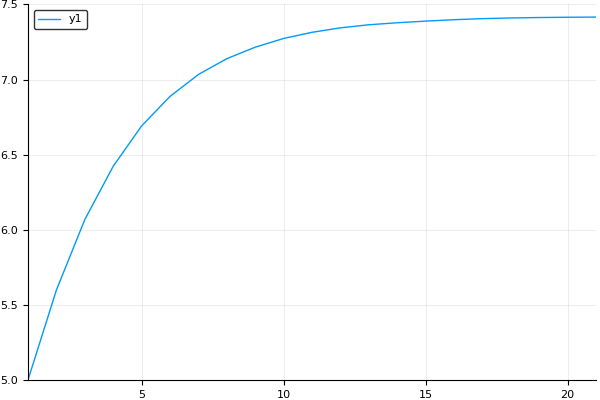

In [21]:
plot(spath_x,xlim=(1,21),ylim = (5,7.5))

In [ ]:
function dpstst(GM::GrowthModel,nsmooth,nnodes,scoord,x)
    smin = scoord[1]
    smax = scoord[end]
    swid = (smax - smin)/nnodes
    smid = linspace(smin+swid/2,smax-swid/2,nnodes)
    xmid = Array{Float64}(length(smid))
    nshocks = 3
    e,w = qnwlogn(nshocks,-(sigma^2)/2,sigma^2)
    
    trans(x) = (g*x) + dot(e*(x^b),w) #state transition function
    
    m = length(w)
    q = ones(size(smid))
    for t in 1:nsmooth
        li = LinInterp(scoord,x)
        for i in 1:length(smid)
            xmid[i] = li(smid[i])
            smid[i] = trans(xmid[i])
        end